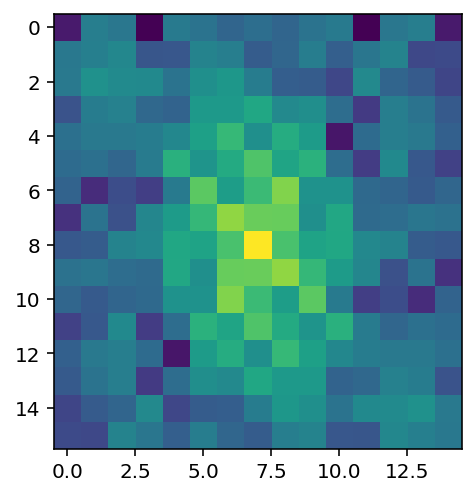

In [1]:
# Import necessary packages
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
import torchvision
from torchsummary import summary
from torch import nn
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from dataloader import FFT_transform_PM
from time import time
import os

In [2]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]

    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [3]:
#I'm using the dataloading code that you uploaded
entries = os.listdir('Data/')

#Importing training data
train_data=[k for k in entries if 'train' in k]

X_title_train=[]
flat_data_train=[]
flat_data_train_raw=[]
X_data_train = []
X_data_train_phase=[]
X_data_train_raw = []
flat_data_train_phase=[]
for entry in train_data:
    name=entry
    #print(entry)
    with open('Data/'+name) as f:
        #print(f)
        for line in f:
            curr = line.strip()
            mat = np.fromstring(curr, dtype=int, sep='  ')
            mat_r = np.reshape(mat, (-1, 15))
            X_data_train_raw.append(mat_r)
            
            #here we apply the FFT transform
            mag_val,phase_val = FFT_transform_PM(mat_r)
            #break
            X_data_train.append(mag_val)
            X_data_train_phase.append(phase_val)
            X_title_train.append(name)
            flat_data_train.append(mag_val.flatten())
            flat_data_train_phase.append(phase_val.flatten())
            flat_data_train_raw.append(mat_r.flatten())
    #X_data_train.append(mag_val)
    #X_data.append (image)

#Importing test data
test_data=[k for k in entries if 'test' in k]
#print(test_data)
X_title_test=[]
X_data_test = []
flat_data_test=[]
X_data_test_phase=[]
X_data_test_raw=[]
flat_data_test_phase=[]
flat_data_test_raw=[]
for entry in test_data:
    name=entry
    #print(entry)
    with open('Data/'+name) as f:
        #print(f)
        for line in f:
            curr = line.strip()
            mat = np.fromstring(curr, dtype=int, sep='  ')
            mat_r = np.reshape(mat, (-1, 15))
            X_data_test_raw.append(mat_r)

            mag_val,phase_val = FFT_transform_PM(mat_r)
            #break
            X_data_test.append(mag_val)
            X_data_test_phase.append(phase_val)
            X_title_test.append(name)
            flat_data_test.append(mag_val.flatten())
            flat_data_test_phase.append(phase_val.flatten())
            flat_data_test_raw.append(mat_r.flatten())
    #X_data.append (image)

#calculate the labels of the data
res_train=[]
res_train = [sub.replace('.txt', '') for sub in X_title_train]
res_train = [sub.replace('train_', '') for sub in res_train]
res_train = [eval(i) for i in res_train]
X_train_lable=res_train
res_test=[]
res_test = [sub.replace('.txt', '') for sub in X_title_test]
res_test = [sub.replace('test_', '') for sub in res_test]
res_test = [eval(i) for i in res_test]
X_test_lable=res_test


x_train=flat_data_train
x_train_raw=flat_data_train_raw
x_train_phase= flat_data_train_phase # added the phase values 
#here I just convert nan to numbers but we might want to look deeper into where the nan values are coming from in the first place
x_train=np.nan_to_num(x_train)
x_train_raw=np.nan_to_num(x_train_raw)
x_train_phase = np.nan_to_num(x_train_phase)
#print(len(flat_data_train))
y_train_temp = X_train_lable
y_train = [float(temp_y) for temp_y in y_train_temp] #Converting to Float; for softmax at output (not mandatory)

x_test=flat_data_test
x_test_raw=flat_data_test_raw
x_test_phase = flat_data_test_phase
x_test=np.nan_to_num(x_test)
x_test_phase= np.nan_to_num(x_test_phase)
y_test_temp = X_test_lable
y_test = [float(temp_yy) for temp_yy in y_test_temp] #Converting to Float; for softmax at output (not mandatory)

#One hot encoding the class labels
enc = OneHotEncoder(handle_unknown='ignore')
enc_y_train = np.array(y_train)
enc_y_train = enc_y_train.reshape(-1, 1)

enc_y_test = np.array(y_test)
enc_y_test = enc_y_test.reshape(-1, 1)

enc.fit(enc_y_train)
# print("Categories:", enc.categories_)
n_y_train = enc.transform(enc_y_train).toarray()
n_y_test = enc.transform(enc_y_test).toarray()

In [4]:
# Layer details for the neural network
input_size = 100
hidden_sizes = [100, 42, 182]
output_size = 10

# Build a feed-forward network
# nn.Conv2d(3, 32, kernel_size = 3
model = nn.Sequential(nn.Conv2d(input_size, hidden_sizes[0], kernel_size = (3,3)),
                      nn.ReLU(),nn.Flatten(),
                      nn.Linear(hidden_sizes[2], hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)


Sequential(
  (0): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=182, out_features=100, bias=True)
  (4): ReLU()
  (5): Linear(in_features=100, out_features=42, bias=True)
  (6): ReLU()
  (7): Linear(in_features=42, out_features=10, bias=True)
  (8): LogSoftmax(dim=1)
)


In [5]:
criterion = nn.NLLLoss()
# images, labels = next(iter(trainloader))
# images = images.view(images.shape[0], -1)
batch_size =100
batch_x, batch_y = next_batch(batch_size, X_data_train_raw, y_train)
batch_x_tensor = torch.from_numpy(batch_x)
batch_x_tensor = batch_x_tensor.to(torch.float32)

batch_y_tensor = torch.from_numpy(batch_y)
batch_y_tensor = batch_y_tensor.type(torch.LongTensor)

logps = model(batch_x_tensor)
loss = criterion(logps, batch_y_tensor)

In [6]:
print(batch_x_tensor.shape)

torch.Size([100, 16, 15])


In [7]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[[[-2.2406e-04,  0.0000e+00, -5.6250e-04],
          [-2.3678e-04, -1.3828e-04, -3.3848e-04],
          [-5.1420e-04, -3.8436e-04, -7.6309e-05]],

         [[-2.2406e-04, -9.0574e-04, -8.6283e-04],
          [-2.3678e-04, -4.3145e-04, -7.3174e-04],
          [-5.3964e-04, -3.0037e-04, -7.6309e-05]],

         [[-1.0946e-03, -7.8652e-04, -8.1196e-04],
          [-3.9330e-04, -5.8794e-04, -8.6283e-04],
          [-4.8698e-04, -4.1230e-04, -4.9629e-04]],

         ...,

         [[-7.2804e-04, -7.2804e-04, -5.5485e-04],
          [-7.2804e-04, -6.1601e-04, -5.5485e-04],
          [-7.2804e-04, -5.0398e-04, -5.0398e-04]],

         [[-7.2804e-04, -6.1601e-04, -5.0398e-04],
          [-7.2804e-04, -6.9070e-04, -5.4132e-04],
          [-7.2804e-04, -6.9070e-04, -5.4132e-04]],

         [[-1.8672e-04, -7.2075e-04, -1.1046e-03],
          [-7.3093e-04, -1.2828e-03, -1.3668e-03],
          [-8.1325e-04, -1.1046e-03, -1.1046e-03]]],


 

In [8]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [9]:
print('Initial weights - ', model[0].weight)

# images, labels = next(iter(trainloader))
# images.resize_(64, 784)
batch_x, batch_y = next_batch(batch_size, X_data_train_raw, y_train)
batch_x_tensor = torch.from_numpy(batch_x)
batch_x_tensor = batch_x_tensor.to(torch.float32)

batch_y_tensor = torch.from_numpy(batch_y)
batch_y_tensor = batch_y_tensor.type(torch.LongTensor)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(batch_x_tensor)
loss = criterion(output, batch_y_tensor)
loss.backward()
print('Gradient -', model[0].weight.grad)


Initial weights -  Parameter containing:
tensor([[[[-3.0466e-03, -1.6025e-02, -2.0212e-02],
          [-2.5914e-02, -2.6559e-02,  2.0361e-02],
          [-2.2111e-03,  2.0457e-02, -2.4808e-02]],

         [[ 7.2916e-03,  1.3717e-02, -2.0350e-02],
          [-3.1564e-02,  9.9641e-03, -4.2203e-03],
          [-2.9981e-03, -2.2138e-02, -3.1373e-02]],

         [[ 4.4105e-03, -1.1324e-02, -1.6295e-02],
          [-1.3915e-02, -1.4659e-02,  2.5123e-03],
          [-1.6238e-02, -7.0458e-03,  1.4669e-02]],

         ...,

         [[-2.6757e-02, -1.3967e-02,  1.6694e-02],
          [ 2.4398e-02, -2.9012e-02, -2.8557e-02],
          [ 1.7905e-02, -7.6486e-03, -1.0100e-02]],

         [[-3.6445e-05, -2.8766e-02, -2.9466e-02],
          [ 2.8032e-02, -3.2587e-02,  1.3273e-02],
          [-2.3798e-02,  2.6698e-02,  2.0019e-02]],

         [[-7.4519e-03, -1.8826e-02,  2.8571e-02],
          [-1.3574e-02, -1.1082e-02,  3.1588e-02],
          [-3.1241e-03, -2.8002e-02, -2.9549e-02]]],


        [[[ 

In [10]:
# Take an update step and few the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)

Updated weights -  Parameter containing:
tensor([[[[-3.0335e-03, -1.6017e-02, -2.0208e-02],
          [-2.5902e-02, -2.6549e-02,  2.0368e-02],
          [-2.1976e-03,  2.0465e-02, -2.4798e-02]],

         [[ 7.2990e-03,  1.3723e-02, -2.0351e-02],
          [-3.1557e-02,  9.9725e-03, -4.2235e-03],
          [-2.9890e-03, -2.2135e-02, -3.1375e-02]],

         [[ 4.4182e-03, -1.1314e-02, -1.6285e-02],
          [-1.3914e-02, -1.4658e-02,  2.5134e-03],
          [-1.6234e-02, -7.0416e-03,  1.4669e-02]],

         ...,

         [[-2.6750e-02, -1.3961e-02,  1.6699e-02],
          [ 2.4405e-02, -2.9006e-02, -2.8550e-02],
          [ 1.7911e-02, -7.6426e-03, -1.0097e-02]],

         [[-3.2325e-05, -2.8765e-02, -2.9466e-02],
          [ 2.8032e-02, -3.2592e-02,  1.3271e-02],
          [-2.3788e-02,  2.6700e-02,  2.0015e-02]],

         [[-7.4418e-03, -1.8813e-02,  2.8582e-02],
          [-1.3568e-02, -1.1074e-02,  3.1598e-02],
          [-3.1137e-03, -2.7994e-02, -2.9545e-02]]],


        [[[ 

In [11]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 60
for e in range(epochs):
    running_loss = 0
#     for images, labels in trainloader:
#         # Flatten MNIST images into a 784 long vector
#         images = images.view(images.shape[0], -1)
    
    batch_x, batch_y = next_batch(batch_size, X_data_train_raw, y_train)
    batch_x_tensor = torch.from_numpy(batch_x)
    batch_x_tensor = batch_x_tensor.to(torch.float32)
    #batch_x_tensor1 = batch_x_tensor.unsqueeze(0)
    #batch_x_tensor1= batch_x_tensor1.reshape(batch_size,1,15,16)

    batch_y_tensor = torch.from_numpy(batch_y)
    batch_y_tensor = batch_y_tensor.type(torch.LongTensor)

    # Training pass
    optimizer.zero_grad()

    output = model(batch_x_tensor)
    loss = criterion(output, batch_y_tensor)

    #This is where the model learns by backpropagating
    loss.backward()

    #And optimizes its weights here
    optimizer.step()

    running_loss += loss.item()
#     else:
    print("Epoch {} - Training loss: {}".format(e, running_loss/len(batch_x_tensor)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.022932798862457277
Epoch 1 - Training loss: 0.022994117736816408
Epoch 2 - Training loss: 0.023288671970367433
Epoch 3 - Training loss: 0.023056771755218506
Epoch 4 - Training loss: 0.023082399368286134
Epoch 5 - Training loss: 0.022988996505737304
Epoch 6 - Training loss: 0.023195466995239257
Epoch 7 - Training loss: 0.023130371570587158
Epoch 8 - Training loss: 0.023157258033752442
Epoch 9 - Training loss: 0.023090379238128664
Epoch 10 - Training loss: 0.02304384708404541
Epoch 11 - Training loss: 0.023033313751220703
Epoch 12 - Training loss: 0.023073904514312744
Epoch 13 - Training loss: 0.022989351749420166
Epoch 14 - Training loss: 0.023023555278778075
Epoch 15 - Training loss: 0.023230130672454833
Epoch 16 - Training loss: 0.02305091142654419
Epoch 17 - Training loss: 0.022922866344451905
Epoch 18 - Training loss: 0.02323232650756836
Epoch 19 - Training loss: 0.02313046932220459
Epoch 20 - Training loss: 0.022954380512237547
Epoch 21 - Training loss: 0

In [12]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 16, 15).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

In [13]:
# batch_x, batch_y = next_batch(batch_size, X_data_test_raw, y_test)
# batch_x_tensor = torch.from_numpy(batch_x)
# batch_x_tensor = batch_x_tensor.to(torch.float32)

# batch_y_tensor = torch.from_numpy(batch_y)
# batch_y_tensor = batch_y_tensor.type(torch.LongTensor)

# # img = images[0].view(1, 784)
# img = batch_x_tensor[0].view(1,240)
# label = batch_y[0]
# # Turn off gradients to speed up this part
# with torch.no_grad():
#     logps = model(img)

# # Output of the network are log-probabilities, need to take exponential for probabilities
# ps = torch.exp(logps)
# probab = list(ps.numpy()[0])
# print("Actual label =", label)
# print("Predicted Digit =", probab.index(max(probab)))
# view_classify(img.view(1, 16, 15), ps)

In [14]:
batch_x, batch_y = next_batch(batch_size, X_data_test_raw, y_test)
batch_x_tensor = torch.from_numpy(batch_x)
batch_x_tensor = batch_x_tensor.to(torch.float32)

batch_y_tensor = torch.from_numpy(batch_y)
batch_y_tensor = batch_y_tensor.type(torch.LongTensor)

# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(batch_x_tensor)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
probab = list(ps.numpy())

In [15]:
probability_arr = []
for i in range(len(probab)):
    temp_arr = list(probab[i])
    probability_arr.append(temp_arr.index(max(temp_arr)))
# probab.index(max(probab))

In [16]:
probability_arr

[5,
 5,
 5,
 5,
 5,
 2,
 5,
 5,
 7,
 9,
 5,
 5,
 4,
 5,
 5,
 4,
 5,
 9,
 5,
 5,
 5,
 5,
 4,
 5,
 5,
 4,
 5,
 5,
 5,
 2,
 9,
 3,
 5,
 7,
 2,
 5,
 5,
 3,
 9,
 5,
 4,
 3,
 5,
 2,
 3,
 3,
 3,
 5,
 5,
 5,
 2,
 4,
 5,
 4,
 9,
 3,
 5,
 5,
 5,
 5,
 5,
 3,
 5,
 8,
 5,
 2,
 9,
 5,
 5,
 5,
 7,
 5,
 5,
 5,
 2,
 5,
 5,
 9,
 5,
 4,
 2,
 5,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 5,
 7,
 3,
 5,
 9,
 3,
 9,
 3]

In [17]:
len(probability_arr)

100

In [18]:
batch_y_tensor

tensor([7, 9, 8, 7, 5, 4, 5, 0, 8, 5, 4, 9, 9, 3, 9, 9, 7, 3, 6, 5, 6, 9, 3, 3,
        9, 5, 6, 4, 2, 8, 6, 0, 3, 9, 5, 7, 6, 5, 3, 5, 5, 8, 2, 9, 4, 2, 8, 0,
        3, 9, 6, 3, 2, 6, 0, 5, 8, 1, 3, 3, 3, 7, 4, 6, 8, 6, 2, 1, 1, 8, 3, 5,
        9, 9, 4, 0, 8, 3, 4, 1, 4, 2, 5, 7, 9, 2, 2, 5, 5, 7, 0, 9, 2, 8, 6, 6,
        6, 1, 0, 3])

In [19]:
len(batch_y_tensor)

100

In [20]:
acc = sum(1 for x,y in zip(probability_arr,batch_y_tensor) if x == y) / len(probability_arr)
print("Accuracy = ", acc*100,"%")

Accuracy =  8.0 %


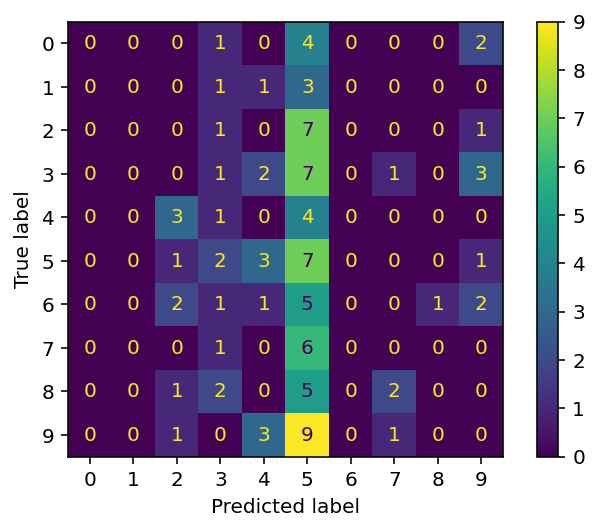

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = batch_y_tensor
y_pred = probability_arr

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()